In [ ]:

import tensorflow

In [ ]:
# TODO: Make all necessary imports.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
from google.colab import drive 
import os
import pandas as pd
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def get_files(base_dir, target_dir):
    count = 0
    path = get_path(base_dir, target_dir)
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            count+=len(glob.glob(os.path.join(dirname, filename)))
        return path, count

def get_path(base_dir, target_dir):
    path = os.path.join(base_dir,target_dir)
    return path

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Data'
train_normal_dir = 'Train/no'
train_tumour_dir = 'Train/yes'
val_normal_dir = 'Val/no'
val_tumour_dir = 'Val/yes'
test_normal_dir = 'Test/no'
test_tumour_dir = 'Test/yes'

train_normal_path, train_normal_count = get_files(base_dir,train_normal_dir)
train_tumour_path, train_tumour_count = get_files(base_dir,train_tumour_dir)

val_normal_path, val_normal_count = get_files(base_dir,val_normal_dir)
val_tumour_path, val_tumour_count = get_files(base_dir,val_tumour_dir)

test_normal_path, test_normal_count = get_files(base_dir,test_normal_dir)
test_tumour_path, test_tumour_count = get_files(base_dir,test_tumour_dir)

# print("No of Train Images: {}".format(train_normal_count + train_pneumonia_count))
# print(" \u2022 No of Normal Images {}".format(train_normal_count))
# print(" \u2022 No of Pneumonia Images {}".format(train_pneumonia_count))

# print("No of Validation Images: {}".format(val_normal_count + val_pneumonia_count))
# print(" \u2022 No of Normal Images {}".format(val_normal_count))
# print(" \u2022 No of Pneumonia Images {}".format(val_pneumonia_count))

# print("No of Test Images: {}".format(test_normal_count + test_pneumonia_count))
# print(" \u2022 No of Normal Images {}".format(test_normal_count))
# print(" \u2022 No of Pneumonia Images {}".format(test_pneumonia_count))

In [ ]:
train_data = []
for filename in os.listdir(train_normal_path):
    train_data.append((os.path.join(train_normal_path,filename),0))

for filename in os.listdir(train_tumour_path):
    train_data.append((os.path.join(train_tumour_path,filename),1))

train_data = pd.DataFrame(train_data, columns=['image_path', 'label'], index=None)
train_data = train_data.sample(frac=1).reset_index(drop=True)
        
val_data = []
for filename in os.listdir(val_normal_path):
    val_data.append((os.path.join(val_normal_path,filename),0))

for filename in os.listdir(val_tumour_path):
    val_data.append((os.path.join(val_tumour_path,filename),1))
        
val_data = pd.DataFrame(val_data, columns=['image_path', 'label'], index=None)
        
test_data = []
for filename in os.listdir(test_normal_path):
    test_data.append((os.path.join(test_normal_path,filename),0))

for filename in os.listdir(test_tumour_path):
    test_data.append((os.path.join(test_tumour_path,filename),1))

test_data = pd.DataFrame(test_data, columns=['image_path', 'label'], index=None)

print("Train Data {}".format(train_data.shape))
print("Validation Data {}".format(val_data.shape))
print("Test Data {}".format(test_data.shape))

Train Data (2340, 2)
Validation Data (1267, 2)
Test Data (881, 2)


In [ ]:
train_data

image_path  label
0     /content/drive/MyDrive/Colab Notebooks/Data/Tr...      1
1     /content/drive/MyDrive/Colab Notebooks/Data/Tr...      0
2     /content/drive/MyDrive/Colab Notebooks/Data/Tr...      1
3     /content/drive/MyDrive/Colab Notebooks/Data/Tr...      1
4     /content/drive/MyDrive/Colab Notebooks/Data/Tr...      0
...                                                 ...    ...
2335  /content/drive/MyDrive/Colab Notebooks/Data/Tr...      1
2336  /content/drive/MyDrive/Colab Notebooks/Data/Tr...      1
2337  /content/drive/MyDrive/Colab Notebooks/Data/Tr...      1
2338  /content/drive/MyDrive/Colab Notebooks/Data/Tr...      0
2339  /content/drive/MyDrive/Colab Notebooks/Data/Tr...      0

[2340 rows x 2 columns]

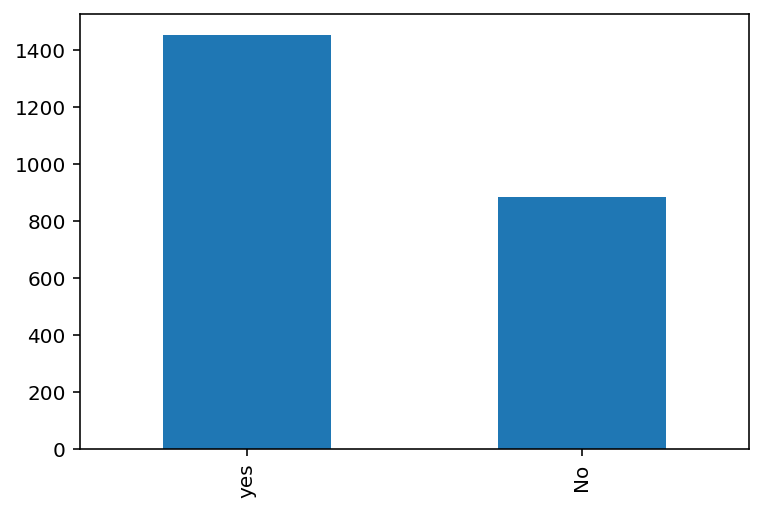

In [ ]:
class_dict = {0:'No', 1:'yes'}
train_data['class_name'] = train_data.label.map(class_dict)
train_data['class_name'].value_counts().plot(kind='bar')

In [ ]:
for filepath in train_data.image_path:
    image = cv2.imread(filepath)
    image_size = image.shape
    break
image_size

(291, 253, 3)

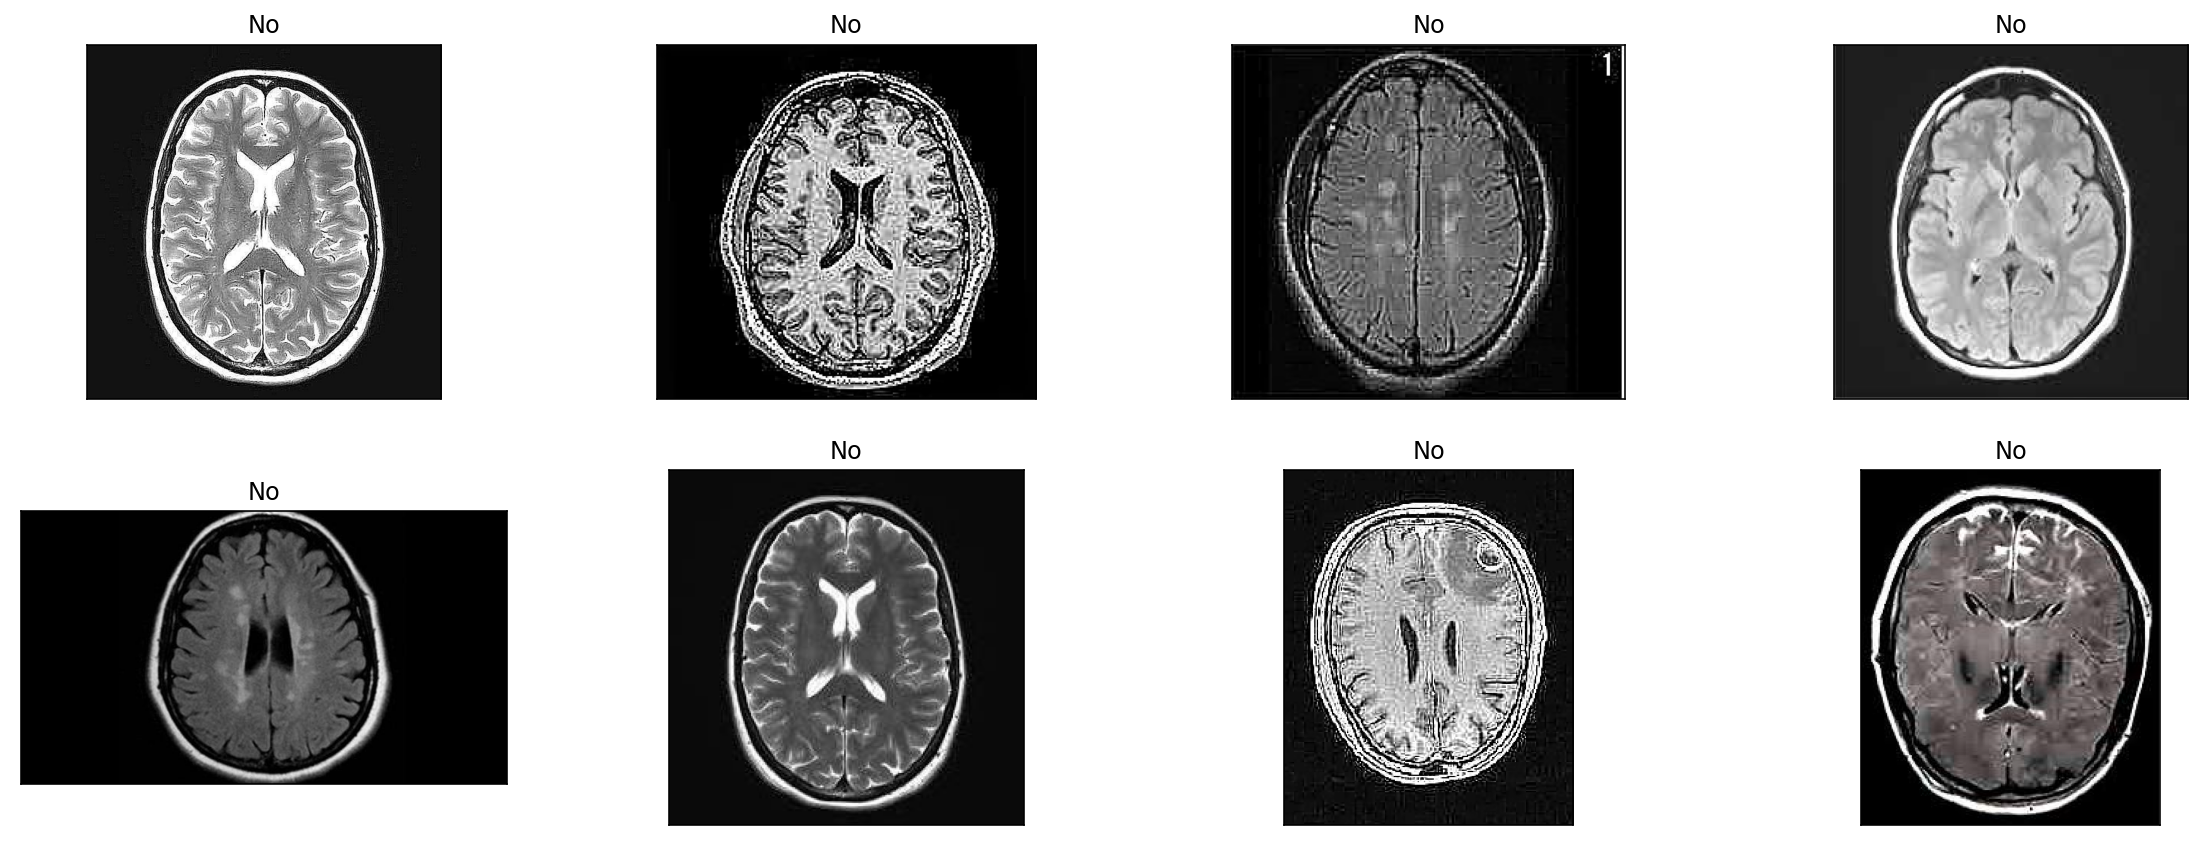

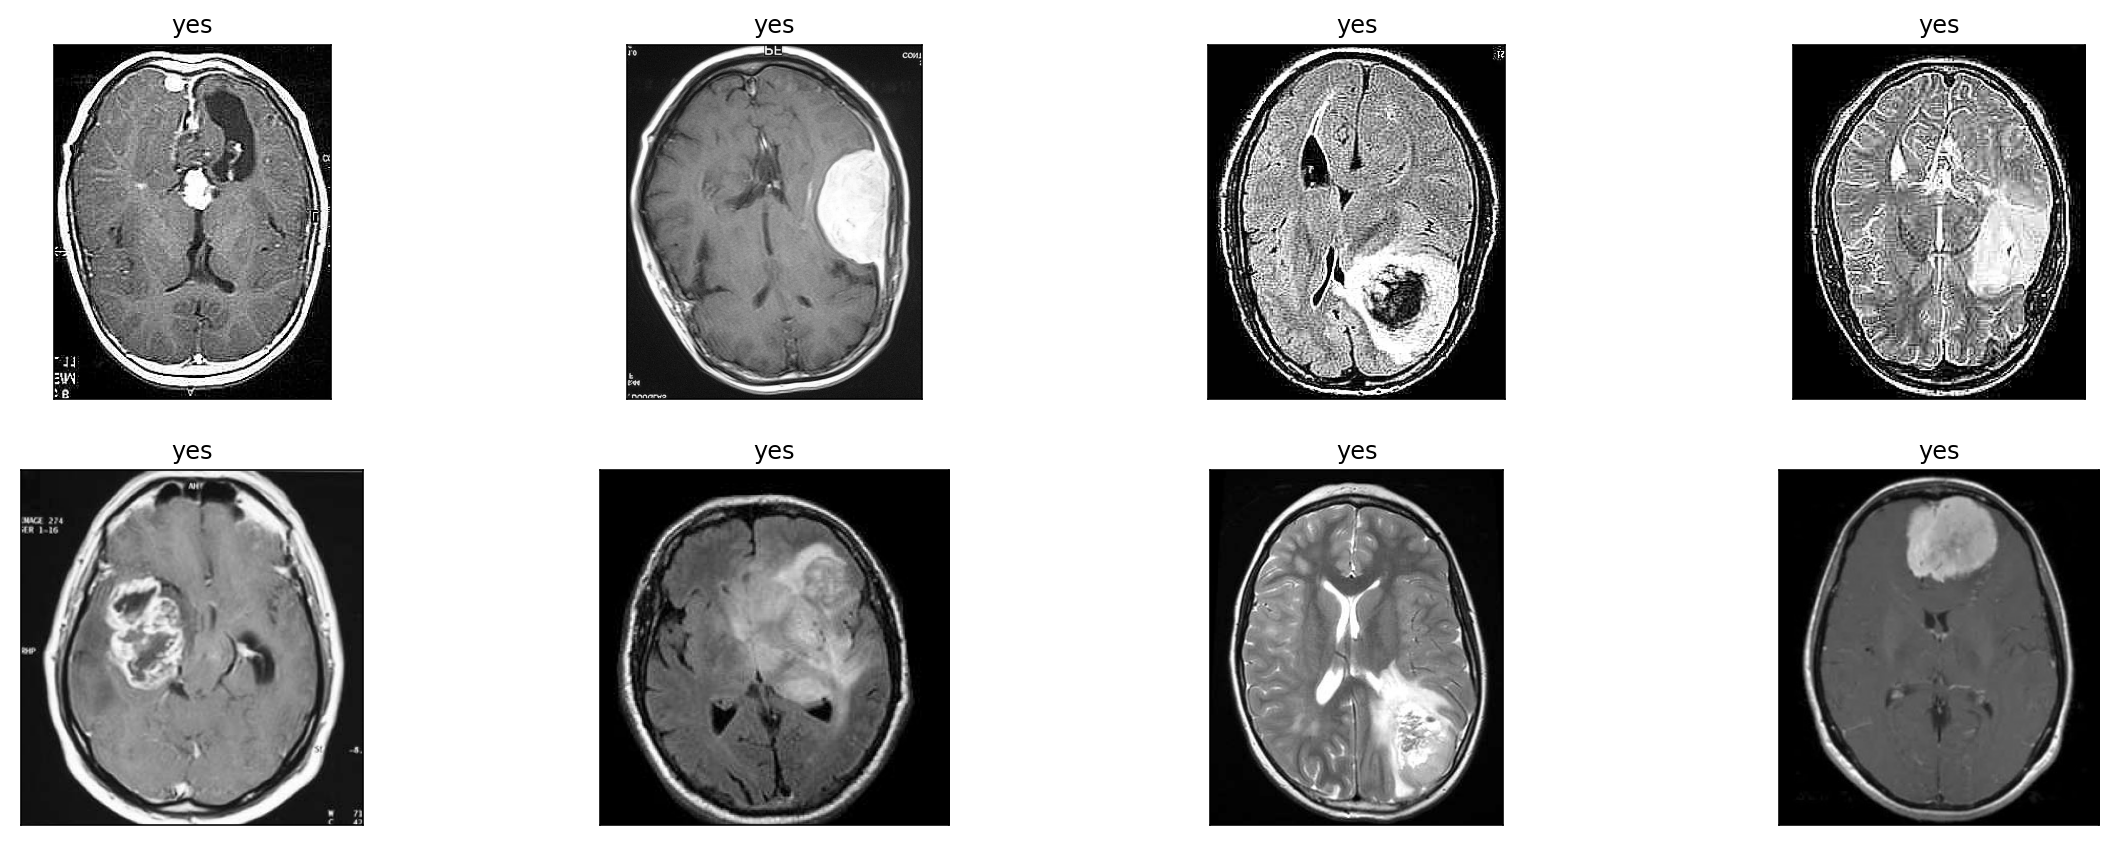

In [ ]:
def visualize_img(images):
    fig = plt.figure(figsize=(20, 15))
    for i,path in enumerate(images):
        fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        img = cv2.imread(path)
        plt.imshow(img)
        plt.title(train_data[train_data.image_path == path].class_name.values[0])
        
for i in range(2):
    images = train_data[train_data.label == i].image_path
    images = np.random.choice(images , 8)
    visualize_img(images)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
BATCH_SIZE = 32
IMG_SHAPE  = 224

train_image_gen = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     brightness_range=[0.2,1.0],
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

train_gen = train_image_gen.flow_from_dataframe(train_data,
                                              x_col='image_path',
                                              y_col='class_name',
                                              class_mode='binary',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2339 validated image filenames belonging to 2 classes.


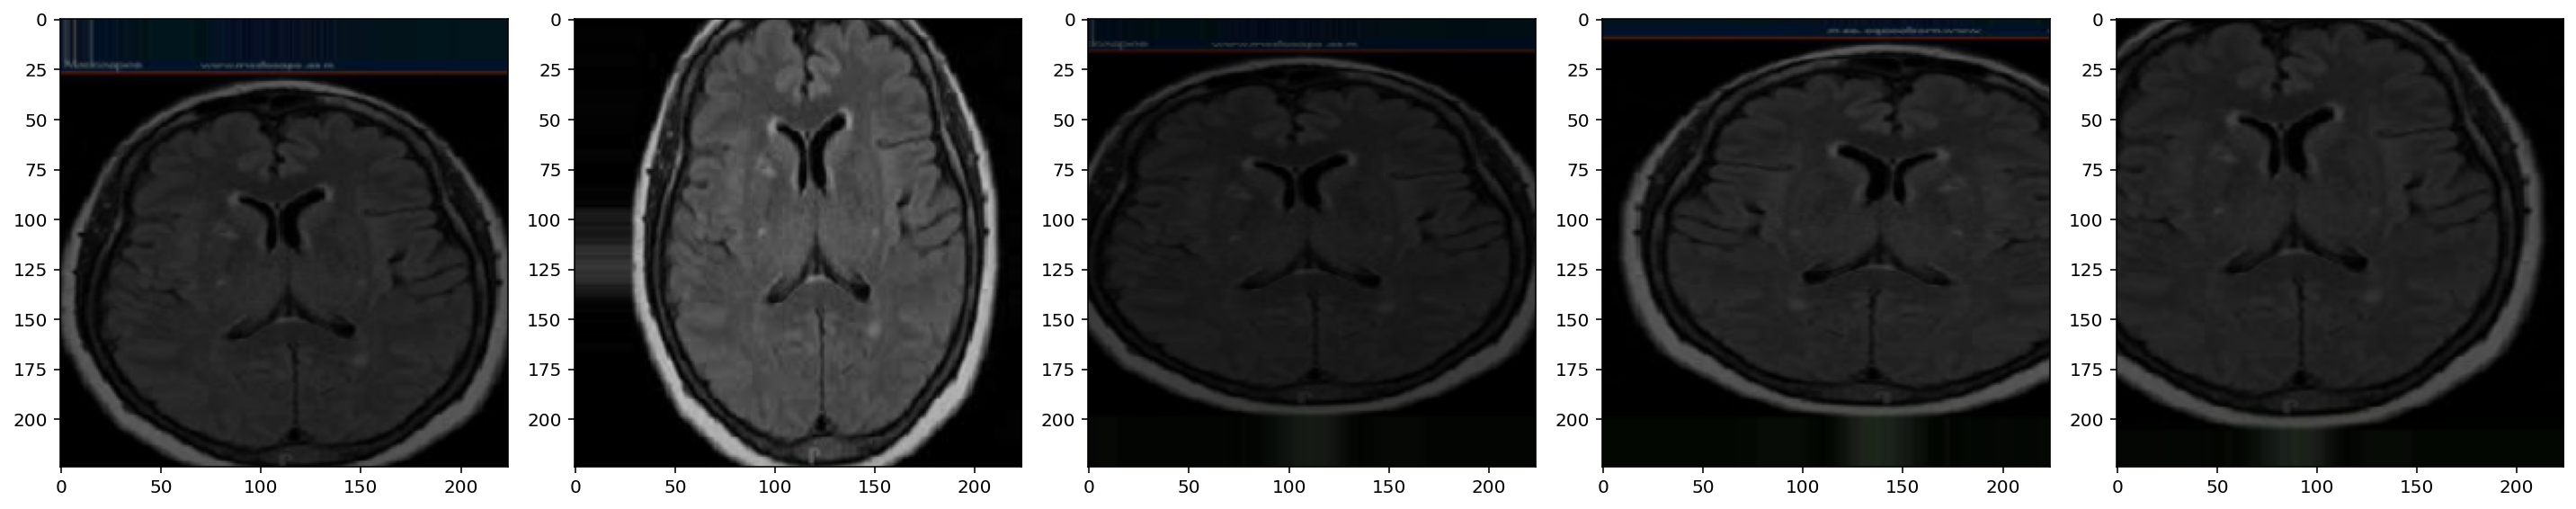

In [ ]:
augmented_images = [train_gen[0][0][2] for i in range(5)]
plotImages(augmented_images)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

train_lb = to_categorical(train_data.label, dtype = int)
val_lb = to_categorical(val_data.label, dtype=int)

train_data = train_data.reset_index().drop(labels='index', axis=1)
y_train = pd.DataFrame(train_lb).add_prefix('label_')

val_data = val_data.reset_index().drop(labels='index', axis=1)
y_val = pd.DataFrame(val_lb).add_prefix('label_')

train_data = pd.concat([train_data, y_train], axis=1)
val_data = pd.concat([val_data, y_val], axis=1)

print("Training set has {} samples".format(train_data.shape[0]))
print("Validation set has {} samples".format(val_data.shape[0]))

Training set has 2340 samples
Validation set has 1267 samples


In [ ]:
BATCH_SIZE = 32
IMG_SHAPE  = 224
EPOCHS = 20

def gen():
    train_image_gen = ImageDataGenerator(rescale=1./255,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         brightness_range=[0.2,1.0],
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         fill_mode='nearest')

    train_gen = train_image_gen.flow_from_dataframe(train_data,
                                              x_col='image_path',
                                              y_col=[f'label_{x}' for x in np.arange(2)],
                                              class_mode='raw',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))


    val_image_gen = ImageDataGenerator(rescale=1./255)

    val_gen = val_image_gen.flow_from_dataframe(val_data,
                                              x_col='image_path',
                                              y_col= [f'label_{x}' for x in np.arange(2)],
                                              class_mode='raw',
                                              batch_size=BATCH_SIZE,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))
    return train_gen, val_gen

In [ ]:
def plot(history):

    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(len(training_accuracy))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
from PIL import Image
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
def process_image(image):
    image = tf.cast(image , tf.float32)
    image = tf.image.resize(image , (224 , 224))
    image = image/255
    image = image.numpy()
    return image

In [ ]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      208       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      1040      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      2

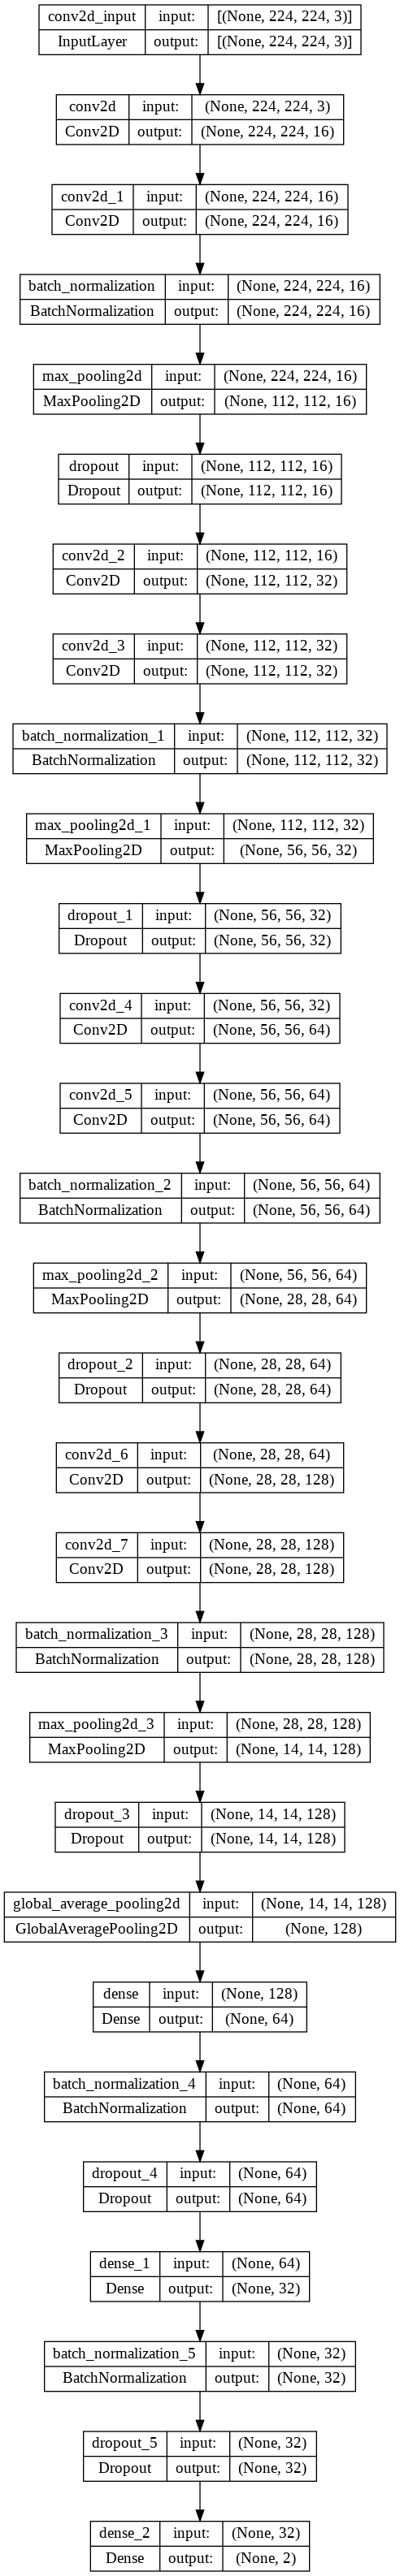

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='baseline_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced', np.unique(train_data['label']), train_data.label)
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(train_data['label']), y= train_data.label)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.3220338983050848, 1: 0.8041237113402062}

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
train_gen, val_gen = gen()

optm = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

EarlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=.0001,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

model_save = ModelCheckpoint('./baseline_model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


base_history = model.fit(train_gen,
                             steps_per_epoch = train_gen.samples // BATCH_SIZE,
                             epochs = 20,
                             validation_data = val_gen,
                             callbacks=[EarlyStopping,model_save],
                             class_weight = class_weights)

Found 2339 validated image filenames.
Found 1267 validated image filenames.
Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.9251 - accuracy: 0.5557
Epoch 1: val_loss improved from inf to 0.71098, saving model to ./baseline_model.h5
73/73 [==============================] - 43s 549ms/step - loss: 0.9251 - accuracy: 0.5557 - val_loss: 0.7110 - val_accuracy: 0.4388
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.8503 - accuracy: 0.6068
Epoch 2: val_loss improved from 0.71098 to 0.70105, saving model to ./baseline_model.h5
73/73 [==============================] - 41s 561ms/step - loss: 0.8503 - accuracy: 0.6068 - val_loss: 0.7011 - val_accuracy: 0.5549
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.8320 - accuracy: 0.6099
Epoch 3: val_loss did not improve from 0.70105
73/73 [==============================] - 41s 559ms/step - loss: 0.8320 - accuracy: 0.6099 - val_loss: 0.7400 - val_accuracy: 0.5612
Epoch 4/20
73/73 [=========

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()

for layer in base.layers:
    layer.trainable = False
    
vgg_model = Sequential()
vgg_model.add(base)
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(BatchNormalization())
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(BatchNormalization())
vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(2, activation='softmax'))

vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
train_gen, val_gen = gen()

optm = Adam(lr=0.0001)
vgg_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

EarlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=.0001,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

model_save = ModelCheckpoint('./vgg16_model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


vgg_history = vgg_model.fit(train_gen,
                             steps_per_epoch = train_gen.samples // BATCH_SIZE,
                             epochs = 20,
                             validation_data = val_gen,
                             callbacks=[EarlyStopping, model_save],
                             class_weight = class_weights)

Found 2339 validated image filenames.
Found 1267 validated image filenames.
Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.8833 - accuracy: 0.5423
Epoch 1: val_loss improved from inf to 0.66406, saving model to ./vgg16_model.h5
73/73 [==============================] - 650s 9s/step - loss: 0.8833 - accuracy: 0.5423 - val_loss: 0.6641 - val_accuracy: 0.5651
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.7698 - accuracy: 0.6051
Epoch 2: val_loss improved from 0.66406 to 0.63690, saving model to ./vgg16_model.h5
73/73 [==============================] - 43s 589ms/step - loss: 0.7698 - accuracy: 0.6051 - val_loss: 0.6369 - val_accuracy: 0.7656
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.6545
Epoch 3: val_loss improved from 0.63690 to 0.60017, saving model to ./vgg16_model.h5
73/73 [==============================] - 43s 586ms/step - loss: 0.7039 - accuracy: 0.6545 - val_loss: 0.6002 - val_accuracy: 0.78

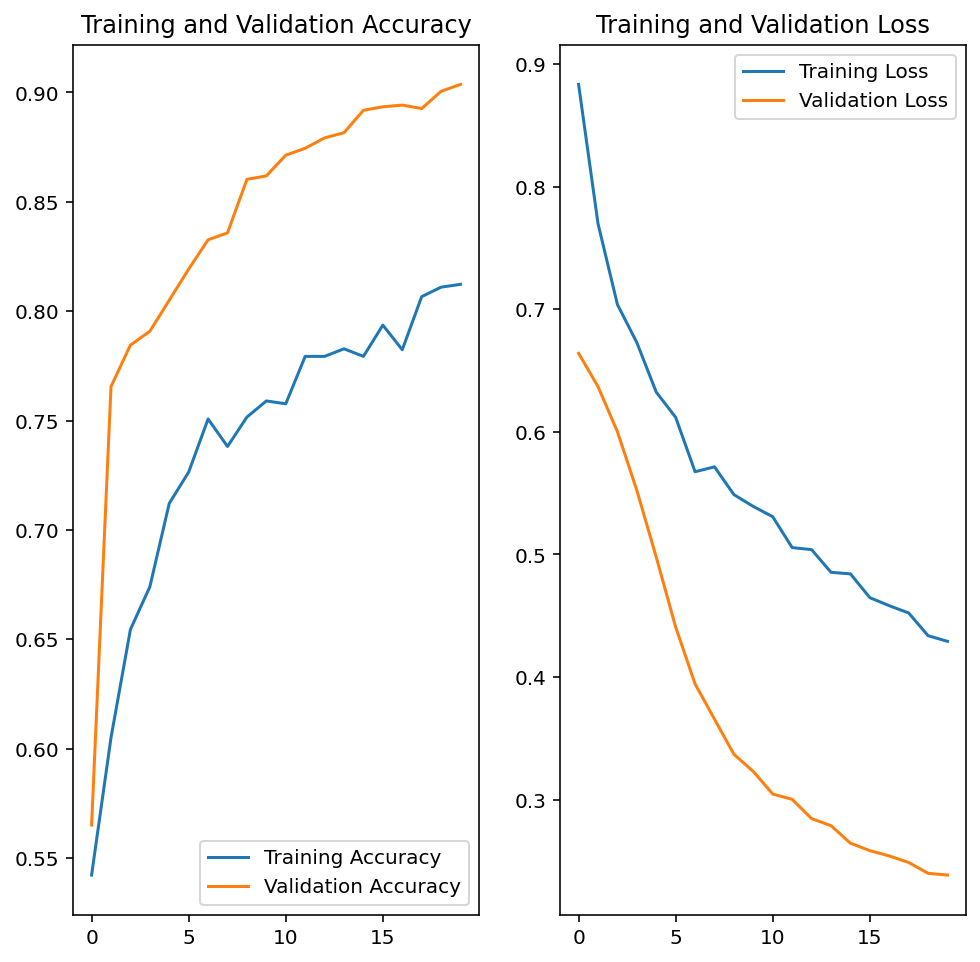

In [ ]:
plot(vgg_history)

In [ ]:
print(vgg_history.history['val_accuracy'][-3])
print(vgg_history.history['val_loss'][-3])

0.8926598429679871
0.24883997440338135


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()
    
for layer in base.layers:
    layer.trainable =  False

mobilenet_model = Sequential()
mobilenet_model.add(base)
mobilenet_model.add(GlobalAveragePooling2D())
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Dense(128, activation='relu'))
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(Dense(2, activation='softmax'))

mobilenet_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0   

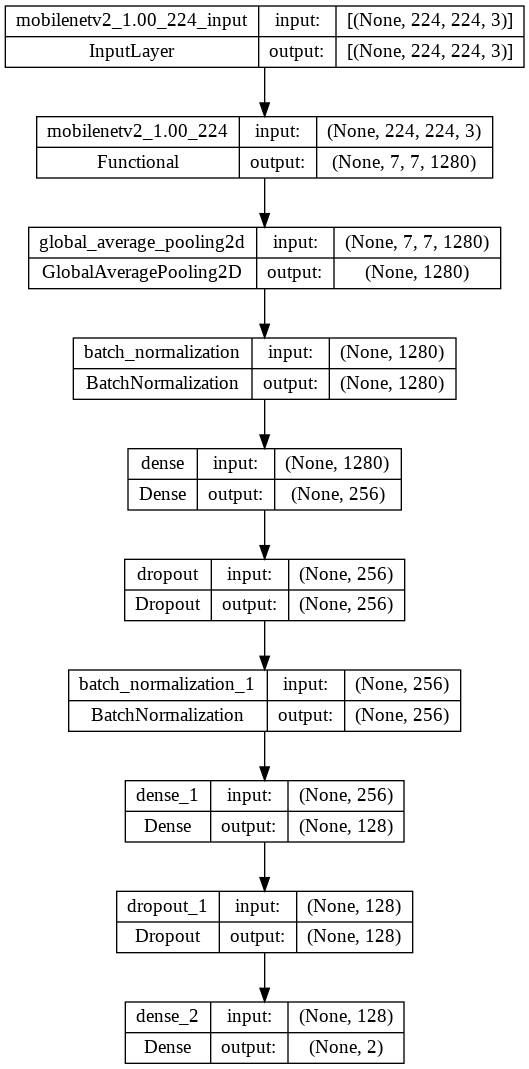

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(mobilenet_model, to_file='mobilenet_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
train_gen, val_gen = gen()

optm = Adam(lr=0.0001)
mobilenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

EarlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=.0001,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

model_save = ModelCheckpoint('./mobilenetV2.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


mob_history = mobilenet_model.fit(train_gen,
                              steps_per_epoch = train_gen.samples // BATCH_SIZE,
                              epochs = 20,
                              validation_data = val_gen,
                              callbacks=[EarlyStopping, model_save])

Found 2339 validated image filenames.
Found 1267 validated image filenames.
Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.3951 - accuracy: 0.8427
Epoch 1: val_loss improved from inf to 0.30673, saving model to ./mobilenetV2.h5
73/73 [==============================] - 44s 562ms/step - loss: 0.3951 - accuracy: 0.8427 - val_loss: 0.3067 - val_accuracy: 0.8690
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.8648
Epoch 2: val_loss improved from 0.30673 to 0.28772, saving model to ./mobilenetV2.h5
73/73 [==============================] - 42s 571ms/step - loss: 0.3495 - accuracy: 0.8648 - val_loss: 0.2877 - val_accuracy: 0.8761
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.3339 - accuracy: 0.8739
Epoch 3: val_loss improved from 0.28772 to 0.26609, saving model to ./mobilenetV2.h5
73/73 [==============================] - 41s 558ms/step - loss: 0.3339 - accuracy: 0.8739 - val_loss: 0.2661 - val_accuracy: 0.

In [ ]:
print(mob_history.history['val_accuracy'][-4])
print(mob_history.history['val_loss'][-4])

0.9344909191131592
0.16041740775108337


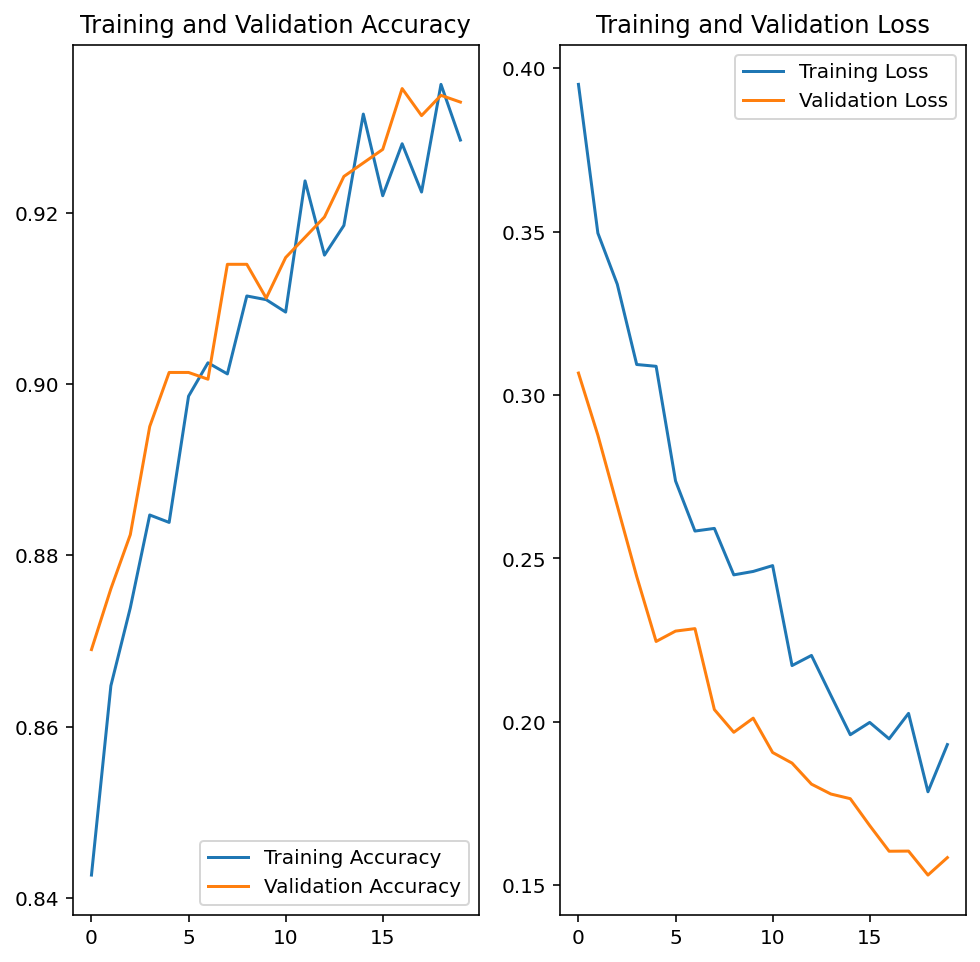

In [ ]:
plot(mob_history)

In [ ]:
t_data=train_data.sample(frac = 1)
mob_pred =[]
count=0
for image in t_data.image_path:
    if(count<180):
       mob_pred.append(predict(image , mobilenet_model))
       count+=1
       print(count)
    else:
        break

1/1 [==============================] - 0s 22ms/step
1
1/1 [==============================] - 0s 18ms/step
2
1/1 [==============================] - 0s 19ms/step
3
1/1 [==============================] - 0s 18ms/step
4
1/1 [==============================] - 0s 24ms/step
5
1/1 [==============================] - 0s 19ms/step
6
1/1 [==============================] - 0s 19ms/step
7
1/1 [==============================] - 0s 20ms/step
8
1/1 [==============================] - 0s 22ms/step
9
1/1 [==============================] - 0s 20ms/step
10
1/1 [==============================] - 0s 18ms/step
11
1/1 [==============================] - 0s 23ms/step
12
1/1 [==============================] - 0s 21ms/step
13
1/1 [==============================] - 0s 19ms/step
14
1/1 [==============================] - 0s 20ms/step
15
1/1 [==============================] - 0s 21ms/step
16
1/1 [==============================] - 0s 18ms/step
17
1/1 [==============================] - 0s 20ms/step
18
1/1 [==============

In [ ]:
from sklearn.metrics import classification_report
final_dense_pred  = np.argmax(mob_pred , axis=-1)
actual_label=t_data['label'][0:180] 

print(classification_report(actual_label, final_dense_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.97      0.97      0.97       109

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



In [ ]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

base = DenseNet169(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()

for layer in base.layers:
    layer.trainable =  False

densenet_model = Sequential()
densenet_model.add(base)
densenet_model.add(GlobalAveragePooling2D())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(2, activation='softmax'))

densenet_model.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1664)             6656      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

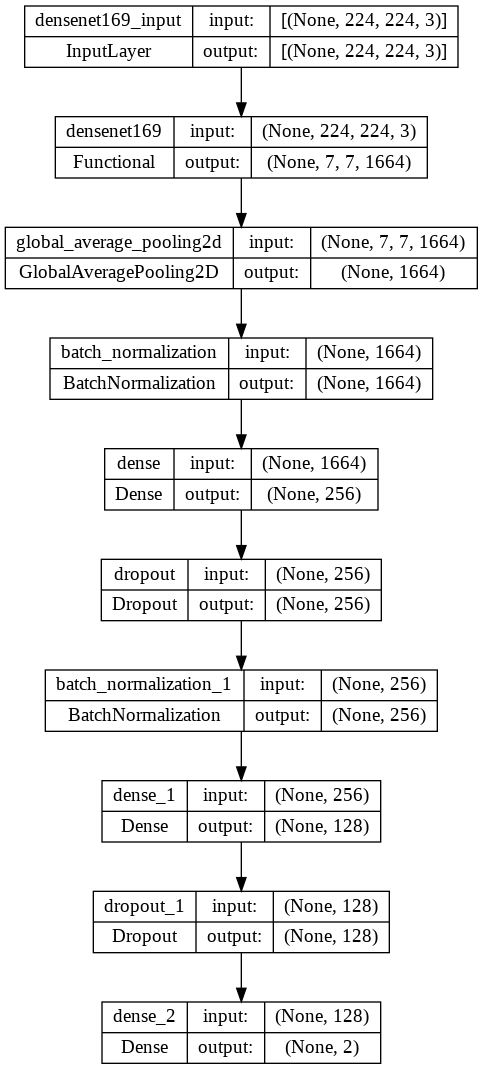

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(densenet_model, to_file='densenet169_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
train_gen, val_gen = gen()

optm = Adam(lr=0.0001)
densenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

EarlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=.0001,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

model_save = ModelCheckpoint('./densenet169.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


dense_history = densenet_model.fit(train_gen,
                              steps_per_epoch = train_gen.samples // BATCH_SIZE,
                              epochs = 20,
                              validation_data = val_gen,
                              callbacks=[EarlyStopping, model_save])

Found 2339 validated image filenames.
Found 1267 validated image filenames.
Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.7396 - accuracy: 0.6155
Epoch 1: val_loss improved from inf to 0.56212, saving model to ./densenet169.h5
73/73 [==============================] - 58s 658ms/step - loss: 0.7396 - accuracy: 0.6155 - val_loss: 0.5621 - val_accuracy: 0.6930
Epoch 2/20
72/73 [============================>.] - ETA: 0s - loss: 0.5840 - accuracy: 0.7483
Epoch 2: val_loss improved from 0.56212 to 0.45500, saving model to ./densenet169.h5
73/73 [==============================] - 44s 606ms/step - loss: 0.5837 - accuracy: 0.7486 - val_loss: 0.4550 - val_accuracy: 0.7845
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.4700 - accuracy: 0.8058
Epoch 3: val_loss improved from 0.45500 to 0.38744, saving model to ./densenet169.h5
73/73 [==============================] - 43s 591ms/step - loss: 0.4700 - accuracy: 0.8058 - val_loss: 0.3874 - val_accuracy: 0.

In [ ]:
t_data=train_data.sample(frac = 1)
t_data

image_path  label class_name  \
143   /content/drive/MyDrive/Colab Notebooks/Data/Tr...      1        yes   
675   /content/drive/MyDrive/Colab Notebooks/Data/Tr...      1        yes   
1560  /content/drive/MyDrive/Colab Notebooks/Data/Tr...      0         No   
1031  /content/drive/MyDrive/Colab Notebooks/Data/Tr...      0         No   
739   /content/drive/MyDrive/Colab Notebooks/Data/Tr...      1        yes   
...                                                 ...    ...        ...   
1460  /content/drive/MyDrive/Colab Notebooks/Data/Tr...      1        yes   
1684  /content/drive/MyDrive/Colab Notebooks/Data/Tr...      0         No   
817   /content/drive/MyDrive/Colab Notebooks/Data/Tr...      1        yes   
1427  /content/drive/MyDrive/Colab Notebooks/Data/Tr...      0         No   
569   /content/drive/MyDrive/Colab Notebooks/Data/Tr...      1        yes   

      label_0  label_1  
143         0        1  
675         0        1  
1560        1        0  
1031        1        0  
739         0        1  
...       ...      ...  
1460        0        1  
1684        1        0  
817         0        1  
1427        1        0  
569         0        1  

[2340 rows x 5 columns]

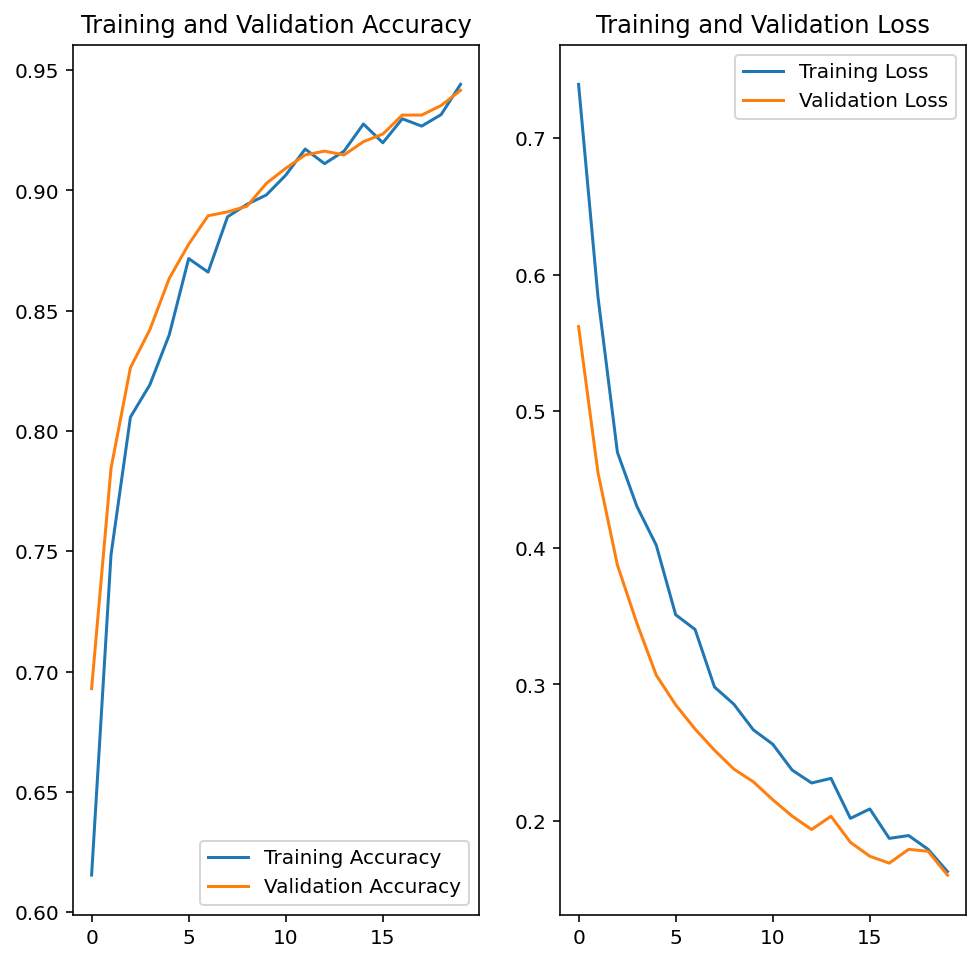

In [ ]:
plot(dense_history)

In [ ]:
dense_pred =[]
count=0
for image in t_data.image_path:
    if(count<1700):
       dense_pred.append(predict(image , densenet_model))
       count+=1
       print(count)
    else:
        break

    
# final_dense_pred  = np.argmax(dense_pred , axis=-1)
# actual_label = test_data['label']

# print(classification_report(actual_label, final_dense_pred))
# matrix=confusion_matrix(actual_label, final_dense_pred)
# sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
#             xticklabels=['0', '1'],
#             yticklabels=['0', '1'])
# plt.xlabel('Predicted label')
# plt.ylabel('True label');

1/1 [==============================] - 0s 35ms/step
1
1/1 [==============================] - 0s 30ms/step
2
1/1 [==============================] - 0s 29ms/step
3
1/1 [==============================] - 0s 34ms/step
4
1/1 [==============================] - 0s 34ms/step
5
1/1 [==============================] - 0s 30ms/step
6
1/1 [==============================] - 0s 31ms/step
7
1/1 [==============================] - 0s 30ms/step
8
1/1 [==============================] - 0s 32ms/step
9
1/1 [==============================] - 0s 33ms/step
10
1/1 [==============================] - 0s 33ms/step
11
1/1 [==============================] - 0s 31ms/step
12
1/1 [==============================] - 0s 32ms/step
13
1/1 [==============================] - 0s 32ms/step
14
1/1 [==============================] - 0s 31ms/step
15
1/1 [==============================] - 0s 30ms/step
16
1/1 [==============================] - 0s 35ms/step
17
1/1 [==============================] - 0s 38ms/step
18
1/1 [==============

In [ ]:
from sklearn.metrics import classification_report
final_dense_pred  = np.argmax(dense_pred , axis=-1)
actual_label=t_data['label'][0:1700] 

print(classification_report(actual_label, final_dense_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       632
           1       0.97      0.99      0.98      1068

    accuracy                           0.97      1700
   macro avg       0.97      0.97      0.97      1700
weighted avg       0.97      0.97      0.97      1700



In [ ]:
print(dense_history.history['val_accuracy'][-4])
print(dense_history.history['val_loss'][-4])

0.9313338398933411
0.1691192388534546


In [ ]:
model1_list=[]
model2_list=[]

predicted_label_list=[]
count=0
for image in t_data.image_path:
   if(count<300):
      model1_list.append(predict(image, densenet_model))
      model2_list.append(predict(image, mobilenet_model))
      count+=1
      print(count)

for mob, dense in zip(model1_list, model2_list):
    predicted_label_list.append(np.argmax(mob/np.linalg.norm(mob) + dense/np.linalg.norm(dense)))

actual_label = t_data['label'][0:300]
print(classification_report(actual_label, predicted_label_list))

1/1 [==============================] - 0s 20ms/step
1
1/1 [==============================] - 0s 18ms/step
2
1/1 [==============================] - 0s 19ms/step
3
1/1 [==============================] - 0s 21ms/step
4
1/1 [==============================] - 0s 19ms/step
5
1/1 [==============================] - 0s 21ms/step
6
1/1 [==============================] - 0s 19ms/step
7
1/1 [==============================] - 0s 19ms/step
8
1/1 [==============================] - 0s 19ms/step
9
1/1 [==============================] - 0s 21ms/step
10
1/1 [==============================] - 0s 22ms/step
11
1/1 [==============================] - 0s 22ms/step
12
1/1 [==============================] - 0s 21ms/step
13
1/1 [==============================] - 0s 19ms/step
14
1/1 [==============================] - 0s 18ms/step
15
1/1 [==============================] - 0s 21ms/step
16
1/1 [==============================] - 0s 19ms/step
17
1/1 [==============================] - 0s 20ms/step
18
1/1 [==============